In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML100k'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'flag_train', 'genres', 'imdbId', 'itemId', 'maxSeqNum',
       'rating', 'seqNum', 'tag', 'timestamp',
       ...
       'f_tag_the', 'f_tag_to', 'f_tag_trek', 'f_tag_wars', 'f_tag_who',
       'f_tag_with', 'f_tag_world', 'f_tag_you', 'user_idx', 'item_idx'],
      dtype='object', length=391)

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_t')].tolist()

In [6]:
denseCols

['f_title_12',
 'f_title_13',
 'f_title_1940',
 'f_title_1954',
 'f_title_1959',
 'f_title_1960',
 'f_title_1962',
 'f_title_1963',
 'f_title_1964',
 'f_title_1967',
 'f_title_1968',
 'f_title_1970',
 'f_title_1971',
 'f_title_1972',
 'f_title_1973',
 'f_title_1974',
 'f_title_1975',
 'f_title_1976',
 'f_title_1977',
 'f_title_1978',
 'f_title_1979',
 'f_title_1980',
 'f_title_1981',
 'f_title_1982',
 'f_title_1983',
 'f_title_1984',
 'f_title_1985',
 'f_title_1986',
 'f_title_1987',
 'f_title_1988',
 'f_title_1989',
 'f_title_1990',
 'f_title_1991',
 'f_title_1992',
 'f_title_1993',
 'f_title_1994',
 'f_title_1995',
 'f_title_1996',
 'f_title_1997',
 'f_title_1998',
 'f_title_1999',
 'f_title_2000',
 'f_title_2001',
 'f_title_2002',
 'f_title_2003',
 'f_title_2004',
 'f_title_2005',
 'f_title_2006',
 'f_title_2007',
 'f_title_2008',
 'f_title_2009',
 'f_title_2010',
 'f_title_2011',
 'f_title_2012',
 'f_title_2013',
 'f_title_2014',
 'f_title_2015',
 'f_title_2016',
 'f_title_2017',
 

In [7]:
genre_to_idx={j:i+1 for i,j in enumerate(dftrain['genres'].unique())}
idx_to_genre={i+1:j for i,j in enumerate(dftrain['genres'].unique())}

In [8]:
dftrain['genre_idx']=[genre_to_idx.get(i) for i in dftrain['genres']]
dfvalid['genre_idx']=[genre_to_idx.get(i) for i in dfvalid['genres']]

In [9]:
catCols=['genre_idx']

### Dataset and DataLoader

In [10]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols,catCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        self.catCols=catCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [11]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols+catCols],dftrain['rating'],denseCols,catCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols+catCols],dfvalid['rating'],denseCols,catCols)

In [12]:
dftrain.shape

(90543, 392)

In [13]:
bs=64

In [14]:
dltrain=DataLoader(dstrain,bs,True)

In [15]:
dlvalid=DataLoader(dsvalid,bs,False)

In [16]:
dftrain['genres'].nunique()

922

In [17]:
[(col, dftrain[col].nunique()) for col in catCols]

[('genre_idx', 922)]

In [18]:
{col: min(50,dftrain[col].nunique()//100) for col in catCols}

{'genre_idx': 9}

In [19]:
emb_szs=[(dftrain[col].nunique(),min(50,dftrain[col].nunique()//100)) for col in catCols]

In [20]:
emb_szs

[(922, 9)]

## Model Architecture

In [21]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
n_emb_genre=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[20,25,10]
dropouts=[0.2,0.3,0.2]

In [22]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [23]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=None

In [24]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 catCols, emb_szs,dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.catCols,self.emb_szs=catCols,emb_szs
        self.len_cat_cols=len(self.catCols)
        self.n_cat_emb=sum([x[1] for x in emb_szs])
        
        
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.embs_cat=nn.ModuleList([nn.Embedding(x+1,y) for x,y in self.emb_szs])
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin_cat= nn.Sequential (nn.Linear(self.n_cat_emb,self.hidden[2]//2),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[2]))
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1+self.hidden[2]//2,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:(2+self.len_dense_cols)]
        out2=self.lin2(denses)
                  
        cats=Xb[:,(2+self.len_dense_cols):].long()
        embed_cat=[self.emb_dropout(self.embs_cat[i](cats[:,i]) ) for i in range(len(self.emb_szs))]
        embedded_cat = torch.cat([x for x in embed_cat],1)
        out_cat=self.lin_cat(embedded_cat)
        
        out3=torch.cat([out1,out2,biased,out_cat],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [25]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [26]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (embs_cat): ModuleList(
    (0): Embedding(923, 9)
  )
  (emb_dropout): Dropout(p=0.05, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin_cat): Sequential(
    (0): Linear(in_features=9, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=51, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [27]:
for Xb, Yb in dltrain:
    break

In [28]:
Xb.shape, Yb.shape

(torch.Size([64, 353]), torch.Size([64, 1]))

In [29]:
Xb.dtype

torch.float32

In [30]:
cfobj.forward(Xb,Yb)

(tensor([[3.0532],
         [2.8383],
         [2.9446],
         [2.9636],
         [2.8557],
         [2.6808],
         [2.9850],
         [2.9540],
         [2.9982],
         [3.0362],
         [2.9532],
         [3.1688],
         [2.9238],
         [2.8715],
         [2.8670],
         [2.9896],
         [2.9960],
         [2.8795],
         [2.7380],
         [2.8885],
         [2.7535],
         [2.6581],
         [3.1812],
         [2.8844],
         [2.9631],
         [2.8448],
         [2.9584],
         [2.9080],
         [2.8958],
         [2.8707],
         [2.8930],
         [3.0269],
         [2.8944],
         [2.8425],
         [2.7093],
         [2.9422],
         [3.0882],
         [2.9735],
         [3.1676],
         [3.1805],
         [2.7354],
         [2.8983],
         [3.0256],
         [3.0608],
         [3.1437],
         [2.8285],
         [2.8435],
         [3.0212],
         [2.7114],
         [3.1398],
         [2.8123],
         [3.0734],
         [2.

## Learner

In [31]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [32]:
device='cuda:1'

In [33]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [34]:
cfobj=cfobj.to(device)

In [35]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (embs_cat): ModuleList(
    (0): Embedding(923, 9)
  )
  (emb_dropout): Dropout(p=0.05, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin_cat): Sequential(
    (0): Linear(in_features=9, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=51, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [36]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [37]:
len(dltrain)

1415

In [38]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

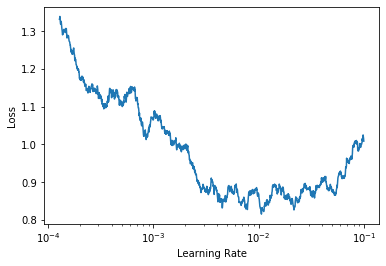

In [39]:
learner.plot_lrs(50)

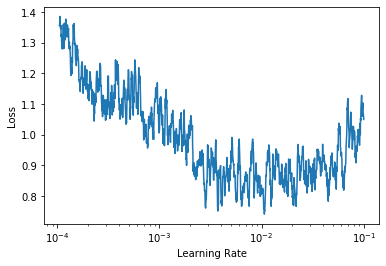

In [40]:
learner.plot_lrs(10)

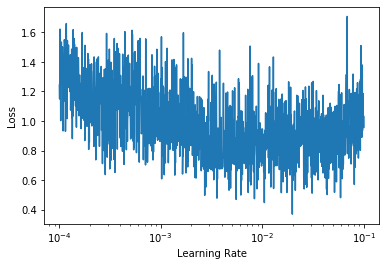

In [41]:
learner.plot_lrs(1)

In [42]:
del cfobj
torch.cuda.empty_cache()

In [43]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [44]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [45]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [46]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4,wd_mult=1.15)

In [47]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.001 Weight Decay 0.0001 Train Loss:0.8076755315802544                 Valid Loss:0.7702666763563334 Train RMSE:0.8902513808445215 Valid RMSE:0.8621540322556165 Train MSE:0.8076755315802544 Valid MSE:0.7702666763563334                 Train MAE:0.698026461904546 Valid MAE:0.6839796393554404
Epoch:1 Learning rate 0.00031622776601683794 Weight Decay 0.00011499999999999999 Train Loss:0.679601983004661                 Valid Loss:0.7608513498898619 Train RMSE:0.8198152745983792 Valid RMSE:0.8565604355255871 Train MSE:0.679601983004661 Valid MSE:0.7608513498898619                 Train MAE:0.6363119519430841 Valid MAE:0.675574417069832
Epoch:2 Learning rate 0.0001 Weight Decay 0.00013225 Train Loss:0.6657078500981887                 Valid Loss:0.7581674803673111 Train RMSE:0.8114388659689218 Valid RMSE:0.8550763174925509 Train MSE:0.6657078500981887 Valid MSE:0.7581674803673111                 Train MAE:0.6296462232990737 Valid MAE:0.6748024967516432
Epoch:3 Learning r

In [48]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [49]:
if 1==1:
    optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.001 Weight Decay 0.0001 Train Loss:0.6862236566341386                 Valid Loss:0.7558711048979196 Train RMSE:0.8238133986092486 Valid RMSE:0.8522814534873574 Train MSE:0.6862236566341386 Valid MSE:0.7558711048979196                 Train MAE:0.6412086091066839 Valid MAE:0.6693035547407518
Epoch:1 Learning rate 0.00031622776601683794 Weight Decay 0.00011499999999999999 Train Loss:0.6190255244713369                 Valid Loss:0.7542658051163513 Train RMSE:0.782241147843428 Valid RMSE:0.8524294466438582 Train MSE:0.6190255244713369 Valid MSE:0.7542658051163513                 Train MAE:0.6053513089675364 Valid MAE:0.6696778404416505
Epoch:2 Learning rate 0.0001 Weight Decay 0.00013225 Train Loss:0.591070031530023                 Valid Loss:0.7492917442914122 Train RMSE:0.7639581731225868 Valid RMSE:0.8493943763214846 Train MSE:0.591070031530023 Valid MSE:0.7492917442914122                 Train MAE:0.5911103172563411 Valid MAE:0.6659199528812622
Epoch:3 Learning 

In [50]:
learner.generate_scores=True

In [53]:
learner.scores=[]
learner.generate_scores=True

In [54]:
%timeit learner.run_epoch(dlvalid,False)

2.56 s ± 83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [85]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8616588857446327

In [86]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [87]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.736355,0.858111,0.657081,0.332833,No-cold-start
1,dnnrec,0.740721,0.860652,0.667503,0.426327,Item-Cold_start
2,dnnrec,1.470968,1.212835,1.108632,-0.601697,User-Cold-Start
0,dnnrec,0.736355,0.858111,0.657081,0.332833,0
1,dnnrec,0.811475,0.900819,0.710244,0.409747,1
0,dnnrec,0.742456,0.861659,0.661399,0.341999,0


In [68]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cfobj_tl_0.8')
torch.save(learner,f=f'{DATAPATH}/inter/cfobj_tl_learner_0.8')
torch.save(optimizer,f=f'{DATAPATH}/inter/cfobj_tl_optimizer_0.8')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cfjobj_tl_state_dict_0.8')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/optimizer_tl_state_dict_0.8')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
results_concat.shape

(66, 6)

In [70]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [71]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))

In [3]:
import pickle
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load (open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','rb'))
results_concat.to_csv(f'{PATH}/ml100k_results.csv',index=False)